# Multinomial Naive Bayes on Breast Cancer Dataset

This notebook implements Multinomial Naive Bayes classifier on the breast cancer dataset and visualizes the results with various plots and performance metrics.

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc, 
                           precision_recall_curve)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Explore the Dataset

In [9]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Classes: {data.target_names}")
print(f"Class distribution:")
print(pd.Series(y).value_counts().sort_index())

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Dataset Information:
Shape: (569, 31)
Features: 30
Classes: ['malignant' 'benign']
Class distribution:
0    212
1    357
Name: count, dtype: int64

First 5 rows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


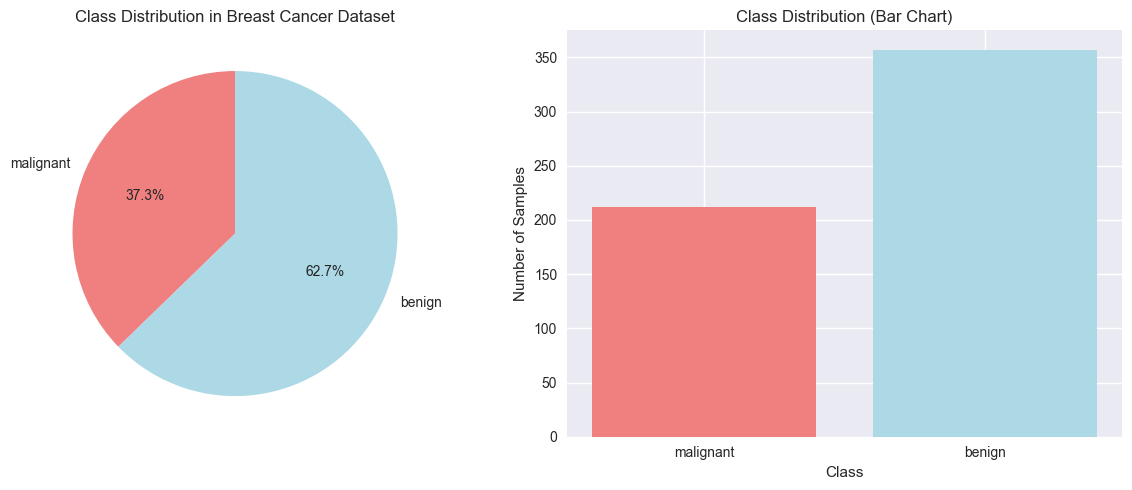

Malignant (0): 212 samples (37.3%)
Benign (1): 357 samples (62.7%)


In [10]:
# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
class_counts = pd.Series(y).value_counts().sort_index()
colors = ['lightcoral', 'lightblue']
plt.pie(class_counts.values, labels=data.target_names, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Class Distribution in Breast Cancer Dataset')

plt.subplot(1, 2, 2)
plt.bar(data.target_names, class_counts.values, color=colors)
plt.title('Class Distribution (Bar Chart)')
plt.ylabel('Number of Samples')
plt.xlabel('Class')

plt.tight_layout()
plt.show()

print(f"Malignant (0): {class_counts[0]} samples ({class_counts[0]/len(y)*100:.1f}%)")
print(f"Benign (1): {class_counts[1]} samples ({class_counts[1]/len(y)*100:.1f}%)")

## 2. Data Preprocessing

Since Multinomial Naive Bayes requires non-negative features (it's designed for discrete counts), we need to scale the features to be non-negative.

In [11]:
# Check for negative values
print("Original data statistics:")
print(f"Min value: {X.min():.3f}")
print(f"Max value: {X.max():.3f}")
print(f"Number of negative values: {(X < 0).sum()}")

# Scale features to [0, 1] range using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("\nAfter MinMax scaling:")
print(f"Min value: {X_scaled.min():.3f}")
print(f"Max value: {X_scaled.max():.3f}")
print(f"Number of negative values: {(X_scaled < 0).sum()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Original data statistics:
Min value: 0.000
Max value: 4254.000
Number of negative values: 0

After MinMax scaling:
Min value: 0.000
Max value: 1.000
Number of negative values: 0

Training set: (455, 30)
Test set: (114, 30)
Training class distribution: [170 285]
Test class distribution: [42 72]


## 3. Feature Analysis and Visualization

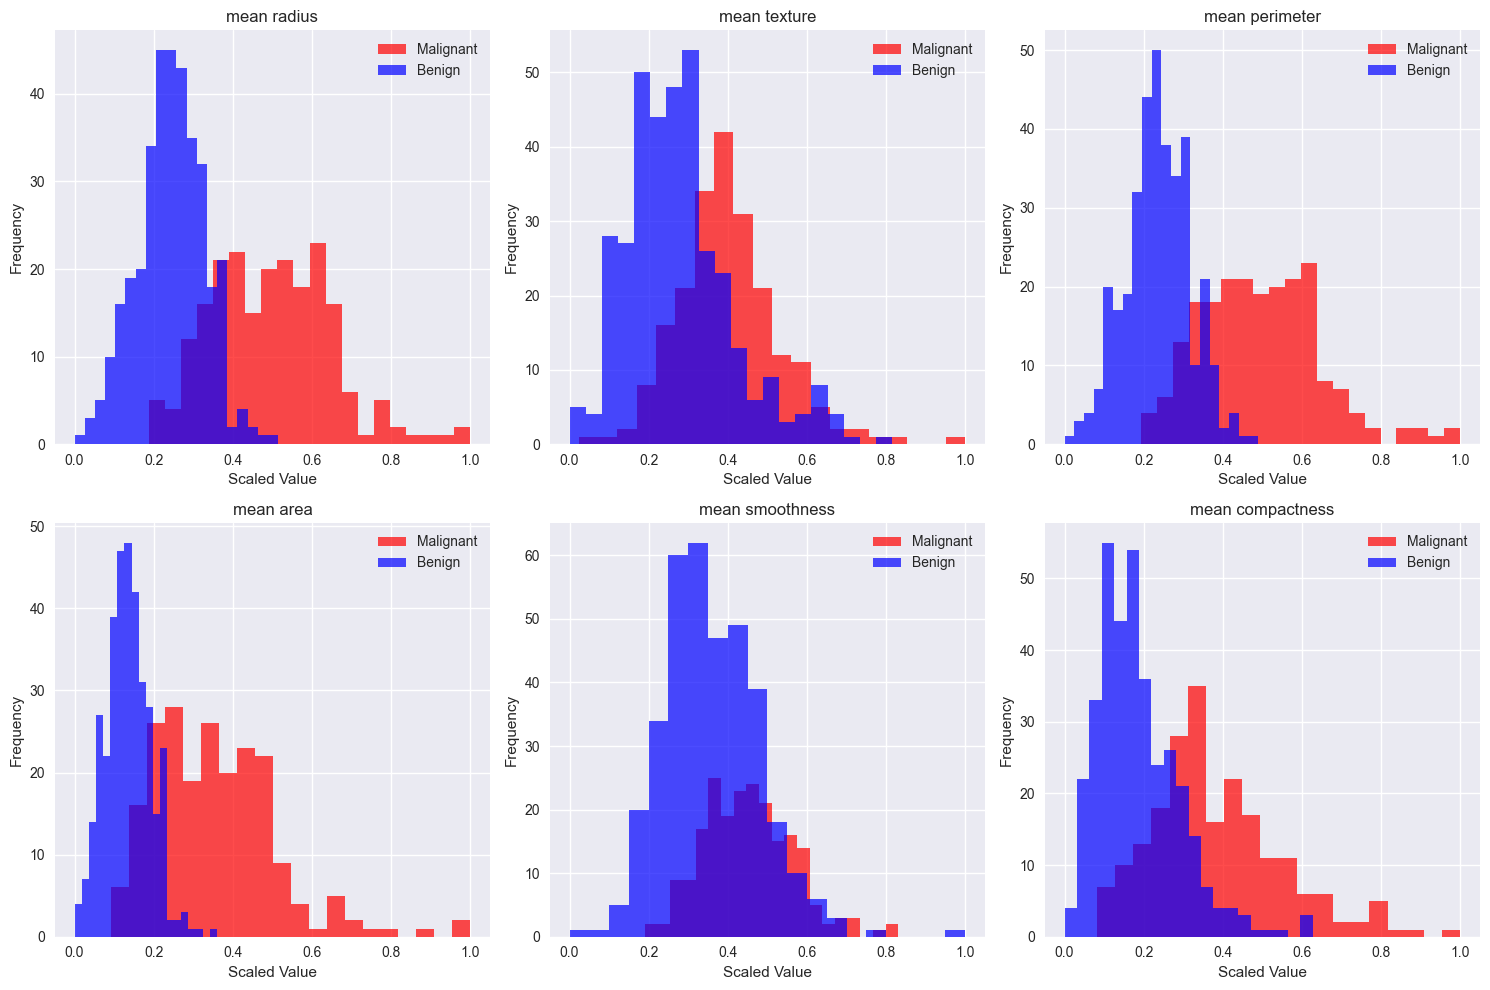

In [12]:
# Visualize some key features
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                'mean smoothness', 'mean compactness']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    
    # Get feature index
    feature_idx = list(data.feature_names).index(feature)
    
    # Plot distributions for each class
    malignant_data = X_scaled[y == 0, feature_idx]
    benign_data = X_scaled[y == 1, feature_idx]
    
    plt.hist(malignant_data, alpha=0.7, label='Malignant', bins=20, color='red')
    plt.hist(benign_data, alpha=0.7, label='Benign', bins=20, color='blue')
    
    plt.title(f'{feature}')
    plt.xlabel('Scaled Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

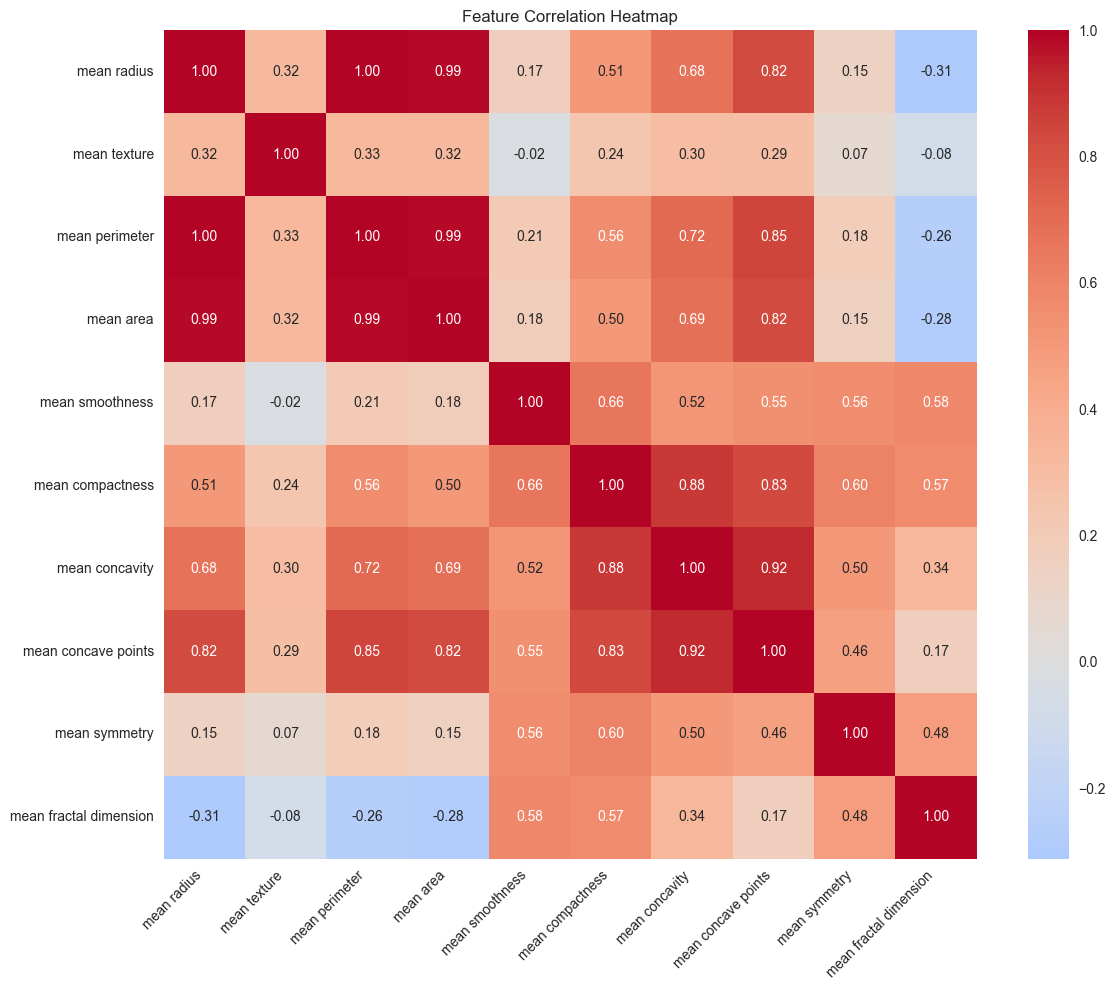

In [13]:
# Correlation heatmap for selected features
plt.figure(figsize=(12, 10))

# Select a subset of features for better visualization
selected_features = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension'
]

# Get indices of selected features
selected_indices = [list(data.feature_names).index(feature) for feature in selected_features]

# Create correlation matrix
correlation_matrix = np.corrcoef(X_scaled[:, selected_indices].T)

# Plot heatmap
sns.heatmap(correlation_matrix, 
            xticklabels=selected_features,
            yticklabels=selected_features,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Multinomial Naive Bayes Implementation

In [14]:
# Create and train Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Make predictions
y_pred = mnb.predict(X_test)
y_pred_proba = mnb.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Multinomial Naive Bayes Accuracy: {accuracy:.4f}")

# Cross-validation score
cv_scores = cross_val_score(mnb, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Multinomial Naive Bayes Accuracy: 0.8509
Cross-validation scores: [0.84615385 0.84615385 0.83516484 0.85714286 0.81318681]
Mean CV score: 0.8396 (+/- 0.0298)


## 5. Model Evaluation and Visualization

In [15]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.60      0.75        42
      benign       0.81      1.00      0.89        72

    accuracy                           0.85       114
   macro avg       0.90      0.80      0.82       114
weighted avg       0.88      0.85      0.84       114



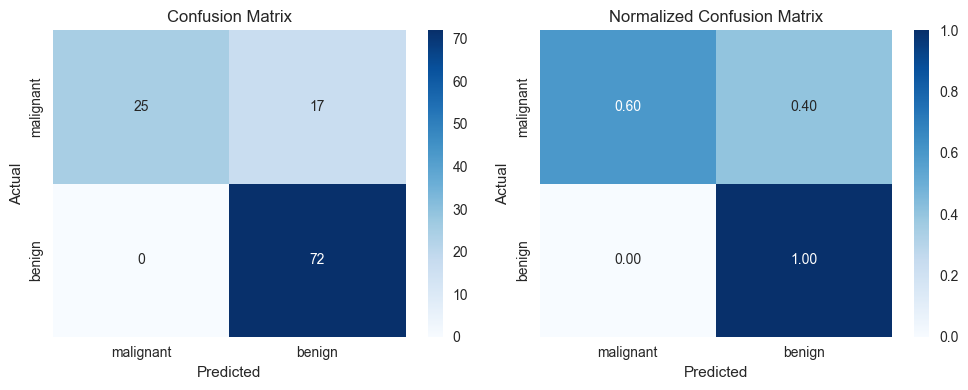

True Negatives: 25
False Positives: 17
False Negatives: 0
True Positives: 72
Sensitivity (Recall): 1.0000
Specificity: 0.5952
Precision: 0.8090
F1-Score: 0.8944


In [16]:
# Confusion Matrix
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
# Normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=data.target_names, 
            yticklabels=data.target_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate confusion matrix metrics
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.4f}")

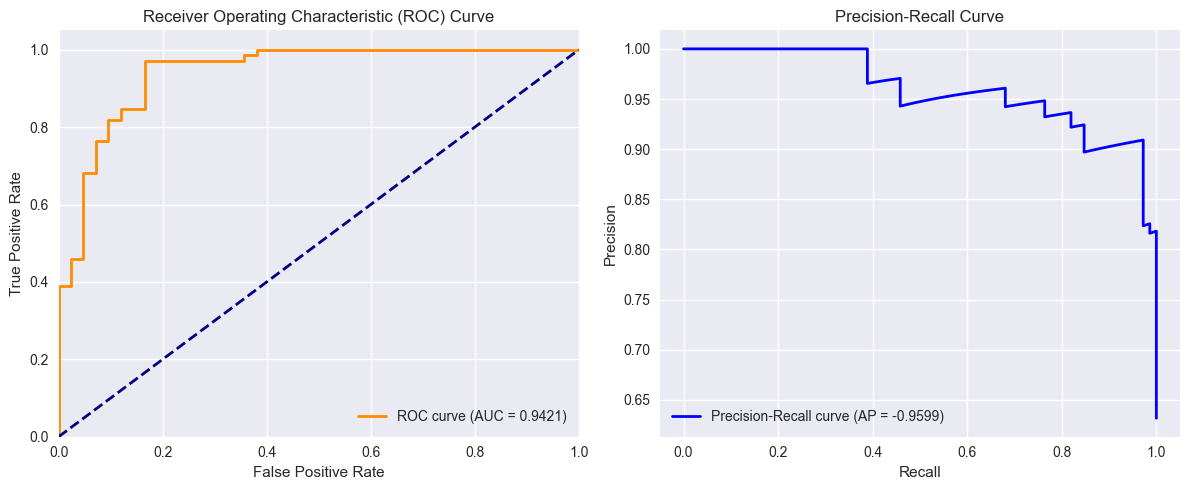

ROC AUC Score: 0.9421
Average Precision Score: -0.9599


In [17]:
# ROC Curve and AUC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
avg_precision = np.trapz(precision, recall)

plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")

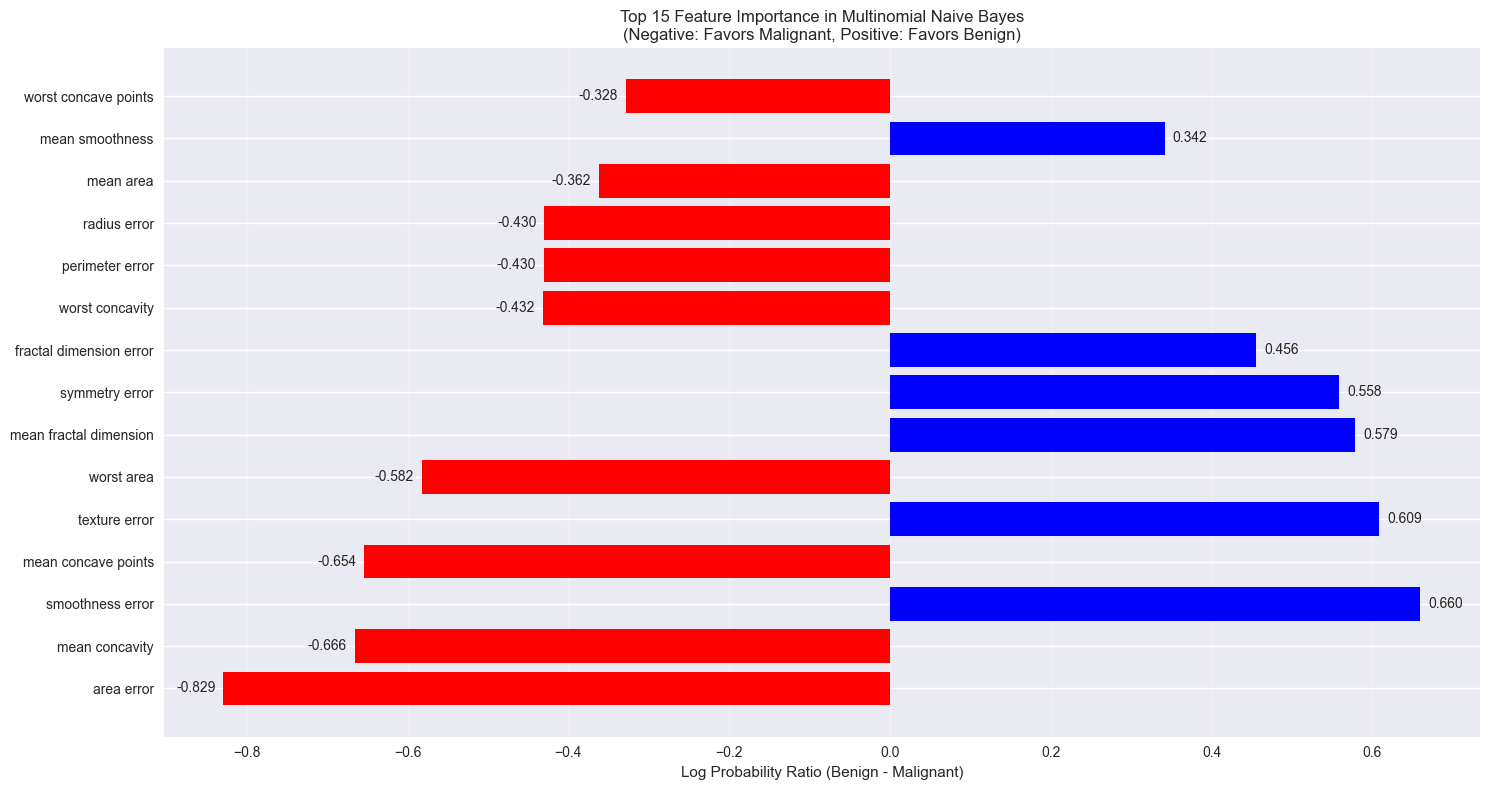

In [18]:
# Feature Importance (Log Probabilities)
plt.figure(figsize=(15, 8))

# Get log probabilities for each feature for each class
log_prob_ratio = mnb.feature_log_prob_[1] - mnb.feature_log_prob_[0]

# Sort features by importance
feature_importance = list(zip(data.feature_names, log_prob_ratio))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

# Plot top 15 most important features
top_features = feature_importance[:15]
features, importances = zip(*top_features)

plt.barh(range(len(features)), importances, color=['red' if imp < 0 else 'blue' for imp in importances])
plt.yticks(range(len(features)), features)
plt.xlabel('Log Probability Ratio (Benign - Malignant)')
plt.title('Top 15 Feature Importance in Multinomial Naive Bayes\n(Negative: Favors Malignant, Positive: Favors Benign)')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (feature, importance) in enumerate(top_features):
    plt.text(importance + (0.01 if importance > 0 else -0.01), i, 
             f'{importance:.3f}', va='center', 
             ha='left' if importance > 0 else 'right')

plt.tight_layout()
plt.show()

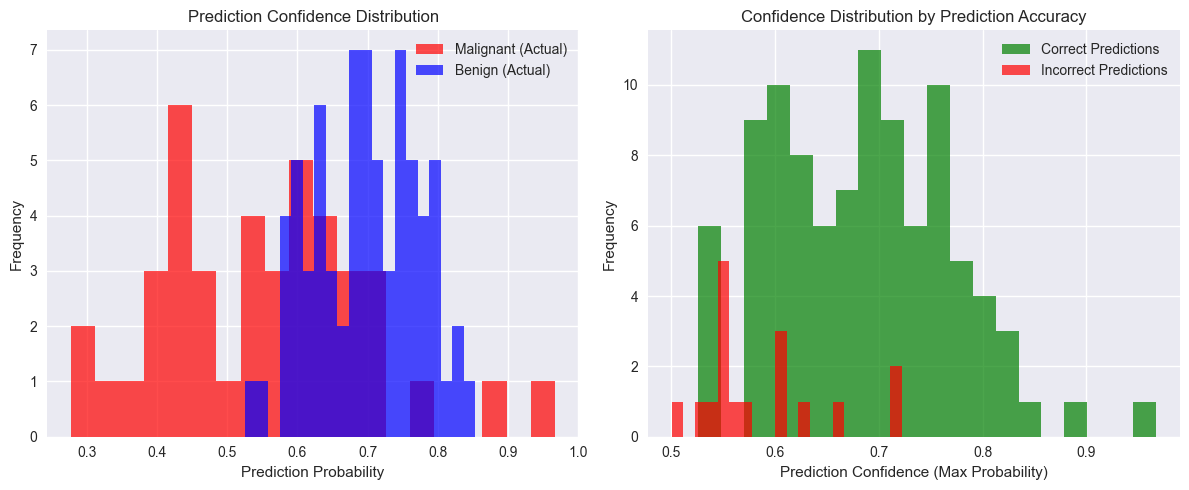

Average confidence for correct predictions: 0.6842
Average confidence for incorrect predictions: 0.5887


In [19]:
# Prediction Confidence Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot prediction probabilities for each class
malignant_probs = y_pred_proba[y_test == 0]
benign_probs = y_pred_proba[y_test == 1]

plt.hist(malignant_probs[:, 0], alpha=0.7, label='Malignant (Actual)', bins=20, color='red')
plt.hist(benign_probs[:, 1], alpha=0.7, label='Benign (Actual)', bins=20, color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()

plt.subplot(1, 2, 2)
# Plot confidence (max probability) distribution
confidence = np.max(y_pred_proba, axis=1)
correct_predictions = (y_pred == y_test)

plt.hist(confidence[correct_predictions], alpha=0.7, label='Correct Predictions', bins=20, color='green')
plt.hist(confidence[~correct_predictions], alpha=0.7, label='Incorrect Predictions', bins=20, color='red')
plt.xlabel('Prediction Confidence (Max Probability)')
plt.ylabel('Frequency')
plt.title('Confidence Distribution by Prediction Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average confidence for correct predictions: {confidence[correct_predictions].mean():.4f}")
print(f"Average confidence for incorrect predictions: {confidence[~correct_predictions].mean():.4f}")

## 6. Model Comparison with Other Naive Bayes Variants

In [20]:
# Compare different Naive Bayes variants
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Train different models
models = {
    'Multinomial NB': MultinomialNB(),
    'Gaussian NB': GaussianNB(),
    'Bernoulli NB': BernoulliNB()
}

results = {}

for name, model in models.items():
    # For Gaussian NB, we can use original scaled data
    # For others, we use the scaled data
    if name == 'Gaussian NB':
        X_train_model = X_train
        X_test_model = X_test
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    model.fit(X_train_model, y_train)
    y_pred_model = model.predict(X_test_model)
    y_pred_proba_model = model.predict_proba(X_test_model)
    
    accuracy = accuracy_score(y_test, y_pred_model)
    cv_score = cross_val_score(model, X_train_model, y_train, cv=5).mean()
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_model[:, 1])
    auc_score = auc(fpr, tpr)
    
    results[name] = {
        'accuracy': accuracy,
        'cv_score': cv_score,
        'auc': auc_score,
        'y_pred': y_pred_model,
        'y_pred_proba': y_pred_proba_model
    }

# Display results
print("Model Comparison:")
print("-" * 60)
print(f"{'Model':<15} {'Accuracy':<10} {'CV Score':<10} {'AUC':<10}")
print("-" * 60)
for name, result in results.items():
    print(f"{name:<15} {result['accuracy']:<10.4f} {result['cv_score']:<10.4f} {result['auc']:<10.4f}")
print("-" * 60)

Model Comparison:
------------------------------------------------------------
Model           Accuracy   CV Score   AUC       
------------------------------------------------------------
Multinomial NB  0.8509     0.8396     0.9421    
Gaussian NB     0.9298     0.9319     0.9868    
Bernoulli NB    0.6316     0.6154     0.5139    
------------------------------------------------------------


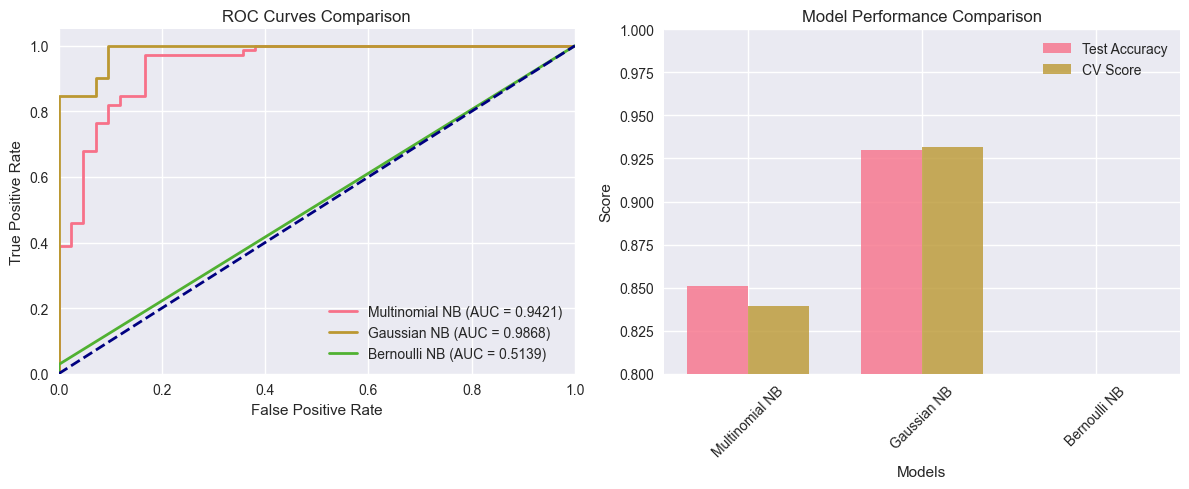

In [21]:
# Plot comparison of ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'][:, 1])
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")

# Plot accuracy comparison
plt.subplot(1, 2, 2)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
cv_scores = [results[name]['cv_score'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Test Accuracy', alpha=0.8)
plt.bar(x + width/2, cv_scores, width, label='CV Score', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

## 7. Summary and Conclusions

In [22]:
# Final summary
print("=== MULTINOMIAL NAIVE BAYES ON BREAST CANCER DATASET ===")
print()
print("Key Findings:")
print(f"• Multinomial NB Accuracy: {results['Multinomial NB']['accuracy']:.4f}")
print(f"• ROC AUC Score: {results['Multinomial NB']['auc']:.4f}")
print(f"• Cross-validation Score: {results['Multinomial NB']['cv_score']:.4f}")
print()

print("Model Comparison Results:")
best_accuracy = max(results.items(), key=lambda x: x[1]['accuracy'])
best_auc = max(results.items(), key=lambda x: x[1]['auc'])
best_cv = max(results.items(), key=lambda x: x[1]['cv_score'])

print(f"• Best Accuracy: {best_accuracy[0]} ({best_accuracy[1]['accuracy']:.4f})")
print(f"• Best AUC: {best_auc[0]} ({best_auc[1]['auc']:.4f})")
print(f"• Best CV Score: {best_cv[0]} ({best_cv[1]['cv_score']:.4f})")
print()

print("Observations:")
print("• Multinomial NB performed well despite being designed for discrete features")
print("• MinMax scaling was essential to make features non-negative")
print("• The model shows good discrimination between malignant and benign cases")
print("• Feature importance analysis reveals which features are most informative")
print("• Cross-validation confirms the model's stability and generalization capability")

=== MULTINOMIAL NAIVE BAYES ON BREAST CANCER DATASET ===

Key Findings:
• Multinomial NB Accuracy: 0.8509
• ROC AUC Score: 0.9421
• Cross-validation Score: 0.8396

Model Comparison Results:
• Best Accuracy: Gaussian NB (0.9298)
• Best AUC: Gaussian NB (0.9868)
• Best CV Score: Gaussian NB (0.9319)

Observations:
• Multinomial NB performed well despite being designed for discrete features
• MinMax scaling was essential to make features non-negative
• The model shows good discrimination between malignant and benign cases
• Feature importance analysis reveals which features are most informative
• Cross-validation confirms the model's stability and generalization capability
